In [1]:
from PIL import Image

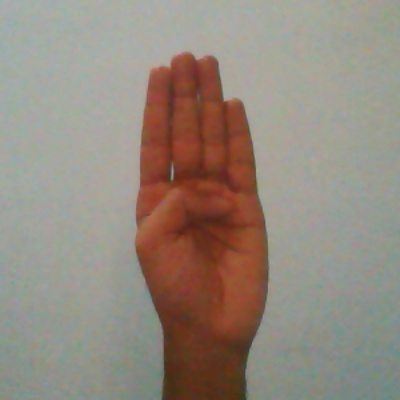

In [12]:
img1 = Image.open('/exchange/dspro2/silent-speech/ASL_Dataset/Test/B/3002.jpg')
img1

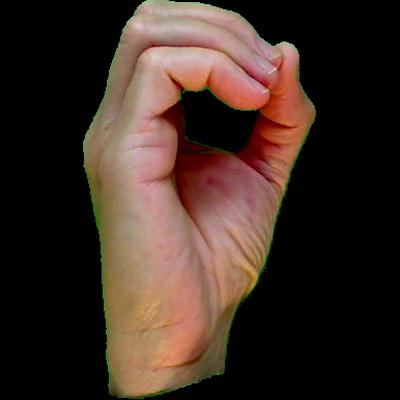

In [7]:
img2 = Image.open('/exchange/dspro2/silent-speech/with-numbers/0/hand1_0_bot_seg_1_cropped.jpeg')
img2

## Imports

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt


In [28]:
#Path
dataset_path = '/exchange/dspro2/silent-speech/full-dataset/'

#Load the dataset
X = np.load(dataset_path + "X_landmarks.npy")
y = np.load(dataset_path + "y_labels.npy")

#Ensure all labels are in uppercase before encoding
y = np.array([label.upper() for label in y])

#Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% Train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% Validation, 15% Test

#Convert labels to numbers (A-Z → 0-26)
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate((y_train, y_val, y_test)))  # Fit on full dataset
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Normalize the landmarks (Standardization: mean=0, std=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Flatten before fitting
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))
# No need to normalize y sets, since it is categorical data.

#Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

Using device: cuda


In [38]:
# To check encoder
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping (Letter → Number):")
print(label_mapping)
print(len(label_mapping))

Label Mapping (Letter → Number):
{np.str_('A'): np.int64(0), np.str_('B'): np.int64(1), np.str_('C'): np.int64(2), np.str_('D'): np.int64(3), np.str_('E'): np.int64(4), np.str_('F'): np.int64(5), np.str_('G'): np.int64(6), np.str_('H'): np.int64(7), np.str_('I'): np.int64(8), np.str_('J'): np.int64(9), np.str_('K'): np.int64(10), np.str_('L'): np.int64(11), np.str_('M'): np.int64(12), np.str_('N'): np.int64(13), np.str_('O'): np.int64(14), np.str_('P'): np.int64(15), np.str_('Q'): np.int64(16), np.str_('R'): np.int64(17), np.str_('S'): np.int64(18), np.str_('SPACE'): np.int64(19), np.str_('T'): np.int64(20), np.str_('U'): np.int64(21), np.str_('V'): np.int64(22), np.str_('W'): np.int64(23), np.str_('X'): np.int64(24), np.str_('Y'): np.int64(25), np.str_('Z'): np.int64(26)}
27


In [33]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_val_tensor.shape)
print(y_val_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)
print(X_train_tensor[0])
print(y_train_tensor[0])

torch.Size([103313, 63])
torch.Size([103313])
torch.Size([22138, 63])
torch.Size([22138])
torch.Size([22139, 63])
torch.Size([22139])
tensor([-0.1441,  0.9763,  1.3506,  0.2429,  0.9996, -0.5833,  0.2953,  0.9317,
        -0.4793, -0.2197,  0.8546, -0.4299, -0.6931,  0.7473, -0.3863,  0.1954,
         0.5282, -0.1769,  0.4365, -0.0543, -0.1488,  0.5003, -0.7022, -0.1492,
         0.4944, -0.9513, -0.1486, -0.4933,  0.5417, -0.1479, -0.8823, -0.1679,
        -0.1309, -1.0475, -0.8929, -0.2491, -1.1170, -1.1600, -0.3137, -0.8542,
         0.7169, -0.1042, -0.8921,  0.6501, -0.3504, -0.6147,  0.7513, -0.4753,
        -0.4299,  0.7817, -0.3998, -0.9184,  0.8938, -0.0430, -0.9077,  0.8323,
        -0.2922, -0.7273,  0.9534, -0.2434, -0.5923,  0.9883, -0.0979],
       device='cuda:0')
tensor(22, device='cuda:0')


In [36]:
import torch.nn as nn
import torch.nn.functional as F

class AslCNN(nn.Module):
    def __init__(self, num_classes):
        super(AslCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(32 * 21 * 3, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, num_classes)  # Output layer
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation since CrossEntropyLoss applies Softmax
        return x


In [39]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim


X_train_tensor = X_train_tensor.view(-1, 1, 21, 3)
X_val_tensor = X_val_tensor.view(-1, 1, 21, 3)
X_test_tensor = X_test_tensor.view(-1, 1, 21, 3)


# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Model, Loss, and Optimizer
num_classes = len(label_encoder.classes_)
model = AslCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch 1, Loss: 0.0841
Epoch 2, Loss: 0.0102
Epoch 3, Loss: 0.0047
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0024
Epoch 6, Loss: 0.0024
Epoch 7, Loss: 0.0017
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0019
Epoch 10, Loss: 0.0007
Training complete!


In [40]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 99.94%
